In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Part 1: EDA

In [2]:
# load data
df = sns.load_dataset('titanic')

In [3]:
# identify null values
df.isna().sum() / len(df) * 100

survived        0.000000
pclass          0.000000
sex             0.000000
age            19.865320
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.224467
class           0.000000
who             0.000000
adult_male      0.000000
deck           77.216611
embark_town     0.224467
alive           0.000000
alone           0.000000
dtype: float64

In [4]:
# drop deck since > 75% is null
df = df.drop(columns=['deck'])

In [5]:
df.loc[:, ~df.columns.isin(['fare', 'age'])].drop_duplicates()

,survived,pclass,sex,sibsp,parch,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,male,1,0,S,Third,man,True,Southampton,no,False
1,1,1,female,1,0,C,First,woman,False,Cherbourg,yes,False
2,1,3,female,0,0,S,Third,woman,False,Southampton,yes,True
3,1,1,female,1,0,S,First,woman,False,Southampton,yes,False
4,0,3,male,0,0,S,Third,man,True,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...
852,0,3,female,1,1,C,Third,child,False,Cherbourg,no,False
858,1,3,female,0,3,C,Third,woman,False,Cherbourg,yes,False
866,1,2,female,1,0,C,Second,woman,False,Cherbourg,yes,False
885,0,3,female,0,5,Q,Third,woman,False,Queenstown,no,False


Redundant pairs:
- survived and alive
- pclass and class
- embarked and embark_town
- who and adult_male

In [6]:
df.loc[:, df.columns.isin(['survived', 'alive'])].drop_duplicates()

,survived,alive
0,0,no
1,1,yes


In [7]:
df.loc[:, df.columns.isin(['pclass', 'class'])].drop_duplicates()

,pclass,class
0,3,Third
1,1,First
9,2,Second


In [8]:
df.loc[:, df.columns.isin(['embarked', 'embark_town'])].drop_duplicates()

,embarked,embark_town
0,S,Southampton
1,C,Cherbourg
5,Q,Queenstown
61,NaN,NaN


In [9]:
df.loc[:, df.columns.isin(['who', 'adult_male'])].drop_duplicates()

,who,adult_male
0,man,True
1,woman,False
7,child,False


In [10]:
# drop redudndant features
df = df.drop(columns=['alive', 'embarked', 'who', 'class'])

df.head()

,survived,pclass,sex,age,sibsp,parch,fare,adult_male,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,True,Southampton,False
1,1,1,female,38.0,1,0,71.2833,False,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,False,Southampton,True
3,1,1,female,35.0,1,0,53.1000,False,Southampton,False
4,0,3,male,35.0,0,0,8.0500,True,Southampton,True


Relationship between sex, age, and adult_male:

`adult_male` is engineered from features 'sex' and 'age', such that if 'age' is greater than or equal to 16 and Y is equal to 'male', then True, else False.


Vectorized Implementation:
```python

df.assign(
    is_adult_male=lambda x: (x['sex'] == 'male') & (x['age'] >= 16)
)

```

In [11]:
# check logic 
# df.loc[(df['adult_male'] == True) & (df['sex'] == 'male'), df.columns.isin(['age', 'sex', 'adult_male'])].drop_duplicates().sort_values(by='age')

In [12]:
# drop adult_male
df = df.drop(columns=['adult_male'])

df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,Southampton,False
1,1,1,female,38.0,1,0,71.2833,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,Southampton,True
3,1,1,female,35.0,1,0,53.1000,Southampton,False
4,0,3,male,35.0,0,0,8.0500,Southampton,True


Explore the data and answer the following questions in markdown cells:

Did more women or men die on the Titanic? 

Show this as 
- a count by sex
- a percentage by sex 
    - that is, of the total number of male passengers, what percentage of males died? 
    - and for the total number of female passengers, what percentage of females did not survive?

In [13]:
# count by sex
death_by_sex = df.loc[df['survived'] == 0, :].groupby(['sex']).agg('count')[['survived']]
print('Count by sex:')
print(death_by_sex)

Count by sex:
        survived
sex             
female        81
male         468


In [14]:
# sex count dataframe
sex_count = pd.DataFrame(
    {'total': [(df['sex'] == 'female').sum(), (df['sex'] == 'male').sum()]},
    index=['female', 'male']
    )

In [15]:
# percentage of deaths by sex (% of sex category that died out of total sex category)
print('Percentage of deaths by sex:')
print((death_by_sex['survived'] / sex_count['total']) * 100)

Percentage of deaths by sex:
sex
female    25.796178
male      81.109185
dtype: float64


__ANS: Based on the results above, more men died than woman.__


What percentages of passengers survived by passenger class?

In [16]:
# answer to the above question ^^
df.groupby('pclass')['survived'].mean() * 100

pclass
1    62.962963
2    47.282609
3    24.236253
Name: survived, dtype: float64

__ANS: ~63% of pclass 1, 47% of pclass 2, and ~24% of pclass 3.__

- id rather be a young woman in 1st class (Rose?) than a man in 3rd class (Jack?)

Describe the distribution of fare values:

__ANS: As seen in the historgram below, the distribution of the fare values is heavily right skewed.__

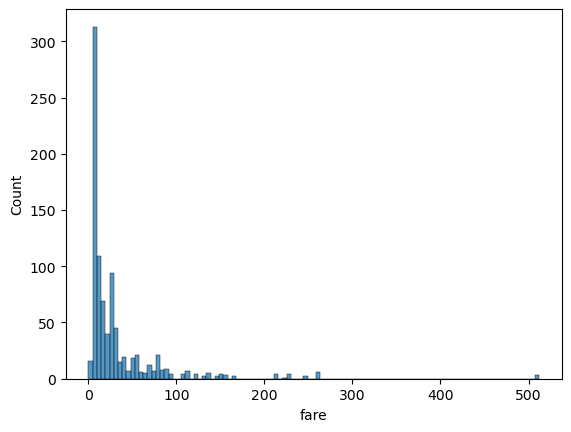

In [17]:
sns.histplot(df['fare']);

Describe the distribution of non-null age values:

__ANS: As seen in the histogram below, the distribution for age is somewhat normal.__


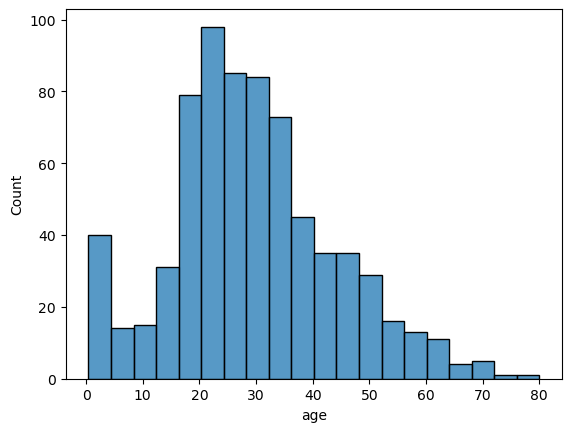

In [18]:
sns.histplot(df['age'].dropna());

What is the median age for each passenger class?

In [19]:
median_age_by_pclass = df.groupby(['pclass']).agg({'age': 'median'}).reset_index()
median_age_by_pclass.rename(columns={'age':'median_age'})

,pclass,median_age
0,1,37.0
1,2,29.0
2,3,24.0


Plot the distributions of age by passenger class in box plots.

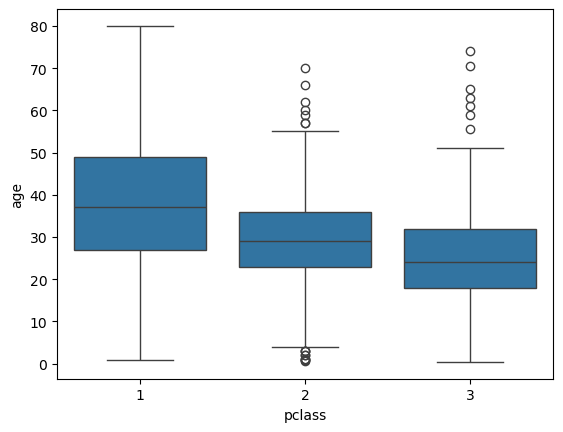

In [20]:
sns.boxplot(x='pclass', y='age', data=df);

In [21]:
# lambda function to impute the null age values with the median value by passenger class
df['age'] = df.groupby('pclass')['age'].transform(lambda x: x.fillna(x.median()))

In [22]:
# sanity check before
df.shape

(891, 9)

In [23]:
df.isna().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embark_town    2
alone          0
dtype: int64

In [24]:
df = df.dropna()

In [25]:
df.isna().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embark_town    0
alone          0
dtype: int64

In [26]:
# sanity check after
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     889 non-null    int64  
 1   pclass       889 non-null    int64  
 2   sex          889 non-null    object 
 3   age          889 non-null    float64
 4   sibsp        889 non-null    int64  
 5   parch        889 non-null    int64  
 6   fare         889 non-null    float64
 7   embark_town  889 non-null    object 
 8   alone        889 non-null    bool   
dtypes: bool(1), float64(2), int64(4), object(2)
memory usage: 63.4+ KB


Based on the values of the columns above, categorical columns should be:
- survived
- pclass
- sex
- embarked
- alone

In [27]:
for col in ['pclass', 'sex', 'embark_town', 'alone']:
    df.loc[:, col] = df.loc[:, col].astype('category')

/var/folders/2x/ff9c3jq93jd0gvcs_p8fh_f00000gn/T/ipykernel_2296/4282416703.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col] = df.loc[:, col].astype('category')
/var/folders/2x/ff9c3jq93jd0gvcs_p8fh_f00000gn/T/ipykernel_2296/4282416703.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col] = df.loc[:, col].astype('category')


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     889 non-null    int64   
 1   pclass       889 non-null    category
 2   sex          889 non-null    category
 3   age          889 non-null    float64 
 4   sibsp        889 non-null    int64   
 5   parch        889 non-null    int64   
 6   fare         889 non-null    float64 
 7   embark_town  889 non-null    category
 8   alone        889 non-null    category
dtypes: category(4), float64(2), int64(3)
memory usage: 45.6 KB


In [29]:
# convert categorical values to dummy variables
df = pd.get_dummies(df)

In [30]:
df

,survived,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,alone_False,alone_True
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,1,0
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0,1,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1,1,0
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,0,1,0,0,1,0,0,1,0,1
887,1,19.0,0,0,30.0000,1,0,0,1,0,0,0,1,0,1
888,0,24.0,1,2,23.4500,0,0,1,1,0,0,0,1,1,0
889,1,26.0,0,0,30.0000,1,0,0,0,1,1,0,0,0,1


In [31]:
# train test split
X = df.loc[:, ~df.columns.isin(['survived'])]
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=432, stratify=y)

In [32]:
# Show that the target rate was maintained between the entire data set, training data, and testing data. 

def calculate_target_rate(y):
    """
    Returns the % of 1's in binary data via mean.
    Args:
        y (array-like) : y target (values = 1 or 0)
    Returns:
        float : percent of target that are 1's
    """
    return np.mean(y == 1)

df_target_rate = calculate_target_rate(y)
y_train_target_rate = calculate_target_rate(y_train)
y_test_target_rate = calculate_target_rate(y_test)

# Print results
print(f"df % of survived = 1: {df_target_rate*100:.2f}%")
print(f"y_train % of survived = 1: {y_train_target_rate*100:.2f}%")
print(f"Testing % of survived = 1:  {y_test_target_rate*100:.2f}%")

df % of survived = 1: 38.25%
y_train % of survived = 1: 38.26%
Testing % of survived = 1:  38.20%


# Part 2: Initial Model Training

1. Instantiate a logistic regression model, a support vector classifier (set probability = True upon instantiation), and a decision tree
classifier into appropriately named variables.  Do not fit these classifiers yet.


2. Using the cross_val_predict functionality from sklearn.model_selection and the training data sets, calculate the probability predictions from each of the three classifiers.  Store the results into appropriately named variables. 
Hint: Use method=‘predict_proba’ for all three algorithms.  


3. Print a classification report, confusion matrix, and ROC-AUC score for each classifier. 
Hint:  Classification report and confusion matrix want class labels for the y_pred parameter.  The 
output of cross_val_predict is in terms of class 0 and class 1 probabilities.  Consider how to identify 
class label predictions from these probabilities

In [33]:
# Create pipelines for each classifier
log_reg = Pipeline([
    ('log_reg', LogisticRegression(max_iter=400, random_state=432))
])

svc = Pipeline([
    ('svc', SVC(probability=True, random_state=432))
])

dt = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=432))
])

In [34]:
y_train_log_reg_proba = cross_val_predict(log_reg, X_train, y_train, method='predict_proba', cv=5)
y_train_svc_proba = cross_val_predict(svc, X_train, y_train, method='predict_proba', cv=5)
y_train_dt_proba = cross_val_predict(dt, X_train, y_train, method='predict_proba', cv=5)

In [35]:
def evaluate_classifier(y_true, y_proba, sk_classifier_object):
    """
    Prints sklearn classifier report, sklearn confusion matrix,
    and sklearn ROC-AUC score.
    Args:
        y_true (array[int]) : binary array of 1's or 0's
        y_proba (array[float]) : array of predicted probabilities
        sk_classifier_object (sklearn classifier) : sklearn pipeline class for classifier
    Returns:
        None
    """
    # Convert probabilities to class labels
    # np.argmax since given (n, 2) matrix with prob of 0 or prob of 1
    y_pred = np.argmax(y_proba, axis=1)
    
    print(f"## {sk_classifier_object} Evaluation")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    print("\nROC-AUC Score:")
    print(roc_auc_score(y_true, y_proba[:, 1]))
    
    print("\n" + "="*50 + "\n")

In [36]:
# Evaluate each classifier
evaluate_classifier(y_train, y_train_log_reg_proba, "Logistic Regression")
evaluate_classifier(y_train, y_train_svc_proba, "Support Vector Classifier")
evaluate_classifier(y_train, y_train_dt_proba, "Decision Tree Classifier")

## Logistic Regression Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       439
           1       0.77      0.68      0.72       272

    accuracy                           0.80       711
   macro avg       0.79      0.78      0.78       711
weighted avg       0.80      0.80      0.80       711


Confusion Matrix:
[[383  56]
 [ 87 185]]

ROC-AUC Score:
0.8440096140962079


## Support Vector Classifier Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.90      0.77       439
           1       0.64      0.30      0.41       272

    accuracy                           0.67       711
   macro avg       0.66      0.60      0.59       711
weighted avg       0.66      0.67      0.63       711


Confusion Matrix:
[[394  45]
 [191  81]]

ROC-AUC Score:
0.7142109406404932


## Decision Tree Classifier Evaluation

Classification Report:
   

# Part 3: Model Tuning

In [37]:
# follow class protocol
scaler = StandardScaler()
scaler.fit(X_train)


X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


y_train_svc_proba_scaled = cross_val_predict(svc, X_train_scaled, y_train, method='predict_proba', cv=5)

In [38]:
# compare scaled SVC vs non-scaled SVC
evaluate_classifier(y_train, y_train_svc_proba_scaled, "Scaled Support Vector Classifier")
evaluate_classifier(y_train, y_train_svc_proba, "Non-scaled Support Vector Classifier")

## Scaled Support Vector Classifier Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       439
           1       0.79      0.65      0.72       272

    accuracy                           0.80       711
   macro avg       0.80      0.77      0.78       711
weighted avg       0.80      0.80      0.80       711


Confusion Matrix:
[[393  46]
 [ 94 178]]

ROC-AUC Score:
0.8220261624011791


## Non-scaled Support Vector Classifier Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.90      0.77       439
           1       0.64      0.30      0.41       272

    accuracy                           0.67       711
   macro avg       0.66      0.60      0.59       711
weighted avg       0.66      0.67      0.63       711


Confusion Matrix:
[[394  45]
 [191  81]]

ROC-AUC Score:
0.7142109406404932




__Non-Scaled SVC Eval:__
- Preciscion on 1: 0.64
- Recall on 1: 0.30
- Accuracy: 0.67
- ROC-AUC Score: 0.71

__Scaled SVC Eval:__
- Preciscion on 1: 0.79
- Recall on 1: 0.65
- Accuracy: 0.80
- ROC-AUC Score: 0.82

__Over all the key metrics for classification metrics, the scaled SVC classifier outperformed the non-scaled SVC classifier.__

In [39]:
# grid search
param_grid = {
    'svc__kernel': ['rbf'],
    'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'svc__C': [1, 10, 50, 100, 200, 300]
}

grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC score:", grid_search.best_score_)

Best parameters: {'svc__C': 100, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
Best ROC-AUC score: 0.8356734402541612


In [40]:
best_svc = grid_search.best_estimator_
#y_test_pred_scaled = best_svc.predict(X_test_scaled)
y_test_proba_scaled = best_svc.predict_proba(X_test_scaled)

evaluate_classifier(y_test, y_test_proba_scaled, "Best SVC Model Evaluation (Test Data)")

## Best SVC Model Evaluation (Test Data) Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.72      0.79       110
           1       0.65      0.85      0.74        68

    accuracy                           0.77       178
   macro avg       0.77      0.79      0.77       178
weighted avg       0.80      0.77      0.77       178


Confusion Matrix:
[[79 31]
 [10 58]]

ROC-AUC Score:
0.880614973262032




/Users/jairusmartinez/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [41]:
# make the prediction on X_test and compare to the true y_test value
y_test_pred_scaled = best_svc.predict(X_test_scaled)
y_test

pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_test_pred_scaled
    })

/Users/jairusmartinez/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


,y_true,y_pred
646,0,0
100,0,1
33,0,0
226,1,0
299,1,1
...,...,...
155,0,1
402,0,1
538,0,0
875,1,1
